In [3]:
!pip install -q sentencepiece
!pip install transformers -q
!pip install wandb -q
!pip install -q rouge-score rouge
!pip install -q beautifulsoup4
!pip install -q matplotlib

In [4]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import re
import wandb
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from transformers import T5Tokenizer,TFT5EncoderModel
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [7]:
wandb.init(project="Text Summarization Finetuning with T5-encoder & LSTM Decoder")
config = wandb.config          # Initialize config
config.TRAIN_BATCH_SIZE = 4    # input batch size for training (default: 64)
config.VALID_BATCH_SIZE = 4    # input batch size for testing (default: 1000)
config.TRAIN_EPOCHS = 10       # number of epochs to train (default: 10)
config.VAL_EPOCHS = 3
config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
config.SEED = 42               # random seed (default: 42)

np.random.seed(config.SEED) # numpy random seed

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Data Loading

In [8]:
data = pd.read_csv("/kaggle/input/text-summarization-dataset/PsychologicalTS.csv", encoding='latin1')

data.head()

Text  \
0  I have to say that I do miss talking to a good...   
1  Actually- no- I reply- admiring my new colou...   
2  Yes. You think you are real and sit there and...   
3  Which manual do you refer to? We have quite a...   
4  Well- since you mentioned it- he says. And ...   

                                           Summariez  
0  The author misses talking to a good psychiatri...  
1  The speaker admits to having a semi-permanent ...  
2  The speaker expresses frustration with their f...  
3  The speaker mentions having a manual and enjoy...  
4  The speaker expresses frustration with the psy...

In [9]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2670 entries, 0 to 2739
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2670 non-null   object
 1   Summariez  2670 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


## Preprocessing

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [12]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [13]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [14]:
#call the function
cleaned_summary = []
for t in data['Summariez']:
    cleaned_summary.append(text_cleaner(t,1))

/tmp/ipykernel_32/3463428437.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [15]:
cleaned_summary[:10]

['the author misses talking to good psychiatrist especially with phd in philosophy and extensive knowledge on madness however psychiatrists often dismiss them quickly and the author finds them tiresome and uninteresting',
 'the speaker admits to having semi permanent psychosis but still leads productive life experiencing magic and faeries they maintain routine but their friends are disinterested as they tire them out',
 'the speaker expresses frustration with their friends who believe they are real and preach their life path while they enjoy their day coffee hair and belief in fairies causing them to tire them out',
 'the speaker mentions having manual and enjoying cappuccino at salon they mention confusion with the staff but are used to their eccentricities they mention bringing bible to read during hairdressing and need to live up to their bipolar diagnosis',
 'the speaker expresses frustration with the psychiatry manual stating that it is useless and sciencey they argue that psychia

In [16]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [17]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

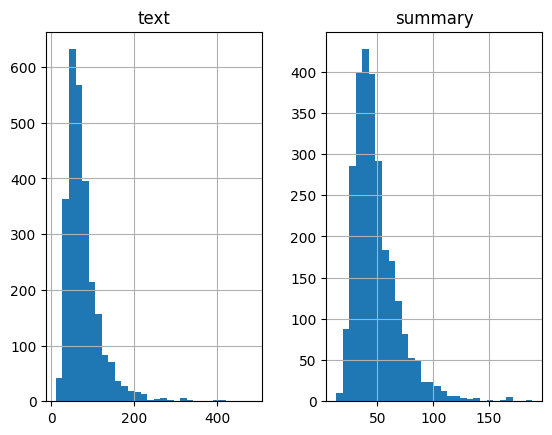

In [18]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [19]:
max(summary_word_count)

189

In [20]:
max_text_len = int(np.percentile(text_word_count, 98))
max_summary_len = int(np.percentile(summary_word_count, 98))
print(f'max_text_len        : {max_text_len}')
print(f'max_summary_lengths : {max_summary_len}')


max_text_len        : 209
max_summary_lengths : 105


In [21]:
df = pd.DataFrame(columns=["ctext", "text"])

In [22]:
df["ctext"] = 'summarize: ' + data.cleaned_text
df["text"] = data.cleaned_summary

df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [23]:
config.MAX_LEN = 512
config.SUMMARY_LEN = 190

In [24]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

def tokenize_data(texts, summaries, max_len_text, max_len_summary):
    inputs = tokenizer(
        texts, 
        add_special_tokens=True,
        max_length=max_len_text, 
        truncation=True, 
        padding='max_length', 
        return_tensors='np'
        )
    
    outputs = tokenizer(
        summaries, 
        max_length=max_len_summary, 
        add_special_tokens=True,
        truncation=True, 
        padding='max_length', 
        return_tensors='np'
        )
    
    return inputs, outputs

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [25]:
max_len_text = config.MAX_LEN  # Define your maximum text length
max_len_summary = config.SUMMARY_LEN  # Define your maximum summary length

In [26]:
text_data = df["ctext"].tolist()
summary_data = df["text"].tolist()

In [27]:
inputs, outputs = tokenize_data(text_data, summary_data, max_len_text, max_len_summary)

In [28]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_inputs, train_outputs = tokenize_data(train_df["ctext"].tolist(), train_df["text"].tolist(), config.MAX_LEN, config.SUMMARY_LEN)
test_inputs, test_outputs = tokenize_data(test_df["ctext"].tolist(), test_df["text"].tolist(), config.MAX_LEN, config.SUMMARY_LEN)


## Model

In [32]:
vocab_size = tokenizer.vocab_size

In [27]:
encoder_model = TFT5EncoderModel.from_pretrained('t5-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5EncoderModel: ['decoder.block.11.layer.0.SelfAttention.q.weight', 'decoder.block.6.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.3.layer.1.EncDecAttention.q.weight', 'decoder.block.8.layer.2.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.2.layer_norm.weight', 'decoder.block.2.layer.2.DenseReluDense.wo.weight', 'decoder.block.8.layer.1.EncDecAttention.q.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.0.SelfAttention.o.weight', 'decoder.block.8.layer.0.layer_norm.weight', 'decoder.block.1.layer.2.layer_norm.weight', 'decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.6.layer.2.layer_norm.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.9.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.2.DenseReluDense.wi.weight', 'decoder.bloc

In [37]:
input_ids = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")

encoder_outputs = encoder_model(input_ids, attention_mask=attention_mask).last_hidden_state

In [66]:
# Embedding layer
decoder_inputs = Input(shape=(config.SUMMARY_LEN,), dtype=tf.int32, name="decoder_inputs")
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size, output_dim=300, 
    input_length=config.SUMMARY_LEN, trainable=False, 
    name="embedding"
)
decoder_inputs_embedded = embedding_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = tf.keras.layers.LSTM(768, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs_embedded, initial_state=[encoder_outputs[:, 0, :], encoder_outputs[:, 0, :]]
)

# Decoder Dense layer
decoder_dense = tf.keras.layers.TimeDistributed(Dense(vocab_size, activation='softmax', name="TD_dec_dense"))
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = tf.keras.Model(inputs=[input_ids, attention_mask, decoder_inputs], outputs=decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 190)]        0           []                               
                                                                                                  
 tft5_encoder_model (TFT5Encode  TFBaseModelOutput(l  109628544  ['input_ids[0][0]',              
 rModel)                        ast_hidden_state=(N               'attention_mask[0][0]']   

In [69]:
# Shifted summary tokens for decoder input during training
decoder_inputs_train = np.zeros_like(train_outputs['input_ids'])
decoder_inputs_train[:, 1:] = train_outputs['input_ids'][:, :-1]
decoder_inputs_train[:, 0] = tokenizer.pad_token_id

# Shifted summary tokens for decoder input during testing
decoder_inputs_test = np.zeros_like(test_outputs['input_ids'])
decoder_inputs_test[:, 1:] = test_outputs['input_ids'][:, :-1]
decoder_inputs_test[:, 0] = tokenizer.pad_token_id


In [72]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6)
]

history = model.fit(
    x=[train_inputs['input_ids'], train_inputs['attention_mask'], decoder_inputs_train],
    y=train_outputs['input_ids'],
    validation_data=(
        [test_inputs['input_ids'], test_inputs['attention_mask'], decoder_inputs_test],
        test_outputs['input_ids']
    ),
    batch_size=8,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
267/267 [==============================] - 280s 1s/step - loss: 2.5232 - accuracy: 0.6907 - val_loss: 2.1613 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 2/50
267/267 [==============================] - 276s 1s/step - loss: 2.1515 - accuracy: 0.6979 - val_loss: 2.1427 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 3/50
267/267 [==============================] - 276s 1s/step - loss: 2.0986 - accuracy: 0.7002 - val_loss: 2.0782 - val_accuracy: 0.7048 - lr: 0.0010
Epoch 4/50
267/267 [==============================] - 276s 1s/step - loss: 2.0504 - accuracy: 0.7019 - val_loss: 2.0388 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 5/50
267/267 [==============================] - 276s 1s/step - loss: 1.9937 - accuracy: 0.7048 - val_loss: 1.9883 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 6/50
267/267 [==============================] - 275s 1s/step - loss: 1.9354 - accuracy: 0.7073 - val_loss: 1.9450 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 7/50
267/267 [==============================] - 275s 1s/st

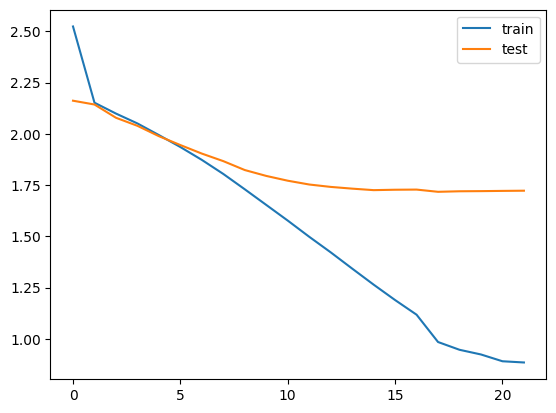

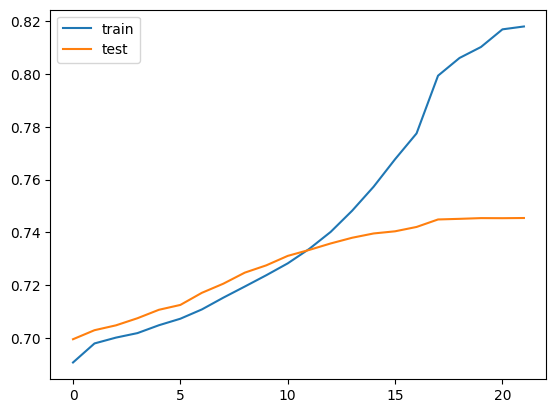

In [73]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Inference Code

In [40]:
def summarize_text(text, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
#     Preprocess input text
    input_text = text
    inputs = tokenizer(
        input_text,
        add_special_tokens=True,
        max_length=max_len_text,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    
    # Initialize decoder input with pad token
    decoder_input = np.zeros((1, max_len_summary), dtype=np.int32)
    decoder_input[:, 0] = tokenizer.pad_token_id

    # Perform inference step-by-step
    for i in range(1, max_len_summary):
        predictions = model.predict([inputs['input_ids'], inputs['attention_mask'], decoder_input])
        next_token = np.argmax(predictions[0, i-1, :])
        decoder_input[0, i] = next_token
        if next_token == tokenizer.eos_token_id:
            break
    
    # Decode the generated ids to text
    summary_ids = decoder_input[0]
    summary = tokenizer.decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return summary

# # Example usage
# example_text = "Your example text goes here."
# summary = summarize_text(example_text)
# print("Generated Summary:", summary)

In [41]:
!pip install rouge-score

In [92]:
from tqdm import tqdm
from rouge_score import rouge_scorer

def evaluate_model(test_texts, test_summaries, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
        'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
        'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
    }
    
    for text, summary in tqdm(zip(test_texts, test_summaries), "Evaluation"):
        generated_summary = summarize_text(text, max_len_text, max_len_summary)
        score = scorer.score(summary, generated_summary)
        
        for metric in ['rouge1', 'rouge2', 'rougeL']:
            scores[metric]['precision'].append(score[metric].precision)
            scores[metric]['recall'].append(score[metric].recall)
            scores[metric]['fmeasure'].append(score[metric].fmeasure)
    
    print("Calculating Mean Scores")
    mean_scores = {
        metric: {
            'precision': np.mean(values['precision']),
            'recall': np.mean(values['recall']),
            'fmeasure': np.mean(values['fmeasure'])
        }
        for metric, values in scores.items()
    }
    
    return mean_scores

test_texts = test_df['ctext'].tolist()
test_summaries = test_df['text'].tolist()
mean_scores = evaluate_model(test_texts, test_summaries)

print("ROUGE scores:")
for metric, values in mean_scores.items():
    print(f"{metric.upper()}: Precision: {values['precision']:.4f}, Recall: {values['recall']:.4f}, F-measure: {values['fmeasure']:.4f}")


In [81]:
print("ROUGE scores:")
for metric, values in mean_scores.items():
    print(f"{metric.upper()}: Precision: {values['precision']:.4f}, Recall: {values['recall']:.4f}, F-measure: {values['fmeasure']:.4f}")


ROUGE scores:
ROUGE1: Precision: 0.2628, Recall: 0.1929, F-measure: 0.2114
ROUGE2: Precision: 0.0450, Recall: 0.0338, F-measure: 0.0366
ROUGEL: Precision: 0.1887, Recall: 0.1388, F-measure: 0.1520


In [45]:
print("With Attention Model")
print("ROUGE scores:")
for metric, values in mean_scores.items():
    print(f"{metric.upper()}: Precision: {values['precision']:.4f}, Recall: {values['recall']:.4f}, F-measure: {values['fmeasure']:.4f}")


With Attention Model
ROUGE scores:
ROUGE1: Precision: 0.1824, Recall: 0.1731, F-measure: 0.1658
ROUGE2: Precision: 0.0275, Recall: 0.0282, F-measure: 0.0264
ROUGEL: Precision: 0.1479, Recall: 0.1406, F-measure: 0.1340


## T5-LSTM Att

In [30]:
from transformers import T5Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Attention, Concatenate, TimeDistributed, Dropout

In [35]:
encoder_model = TFT5EncoderModel.from_pretrained('t5-base')

input_ids = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")

encoder_outputs = encoder_model(input_ids, attention_mask=attention_mask).last_hidden_state

# Embedding layer
decoder_inputs = Input(shape=(config.SUMMARY_LEN,), dtype=tf.int32, name="decoder_inputs")
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size, output_dim=300, 
    input_length=config.SUMMARY_LEN, trainable=False, 
    name="embedding"
)
decoder_inputs_embedded = embedding_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = tf.keras.layers.LSTM(768, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs_1, _, _ = decoder_lstm(
    decoder_inputs_embedded, initial_state=[encoder_outputs[:, 0, :], encoder_outputs[:, 0, :]]
)
decoder_outputs_1 = tf.keras.layers.Dropout(0.2)(decoder_outputs_1)

decoder_lstm2 = tf.keras.layers.LSTM(768, return_sequences=True, return_state=True, name="decoder_lstm2")
decoder_outputs_2, _, _ = decoder_lstm2(
    decoder_outputs_1, initial_state=[encoder_outputs[:, 0, :], encoder_outputs[:, 0, :]]
)
decoder_outputs_2 = tf.keras.layers.Dropout(0.2)(decoder_outputs_2)

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs_2])

decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs_2, attn_out])

# Decoder Dense layer
decoder_dense = tf.keras.layers.TimeDistributed(Dense(320, name="TD_dec_dense"))
decoder_outputs = decoder_dense(decoder_concat_input)

decoder_dense = tf.keras.layers.TimeDistributed(Dense(vocab_size, activation='softmax', name="TD_dec_dense"))
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = tf.keras.Model(inputs=[input_ids, attention_mask, decoder_inputs], outputs=decoder_outputs)

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5EncoderModel: ['decoder.block.6.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.10.layer.1.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.q.weight', 'decoder.block.10.layer.2.layer_norm.weight', 'decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.5.layer.0.layer_norm.weight', 'decoder.block.7.layer.1.EncDecAttention.v.weight', 'decoder.block.9.layer.1.EncDecAttention.q.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.7.layer.1.EncDecAttention.q.weight', 'decoder.block.7.layer.0.SelfAttention.v.weight', 'decoder.block.8.layer.0.SelfAttention.v.weight', 'decoder.block.8.layer.1.EncDecAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.k.weig

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 190)]        0           []                               
                                                                                                  
 tft5_encoder_model_2 (TFT5Enco  TFBaseModelOutput(l  109628544  ['input_ids[0][0]',              
 derModel)                      ast_hidden_state=(N               'attention_mask[0][0]']   

In [36]:
# Shifted summary tokens for decoder input during training
decoder_inputs_train = np.zeros_like(train_outputs['input_ids'])
decoder_inputs_train[:, 1:] = train_outputs['input_ids'][:, :-1]
decoder_inputs_train[:, 0] = tokenizer.pad_token_id

# Shifted summary tokens for decoder input during testing
decoder_inputs_test = np.zeros_like(test_outputs['input_ids'])
decoder_inputs_test[:, 1:] = test_outputs['input_ids'][:, :-1]
decoder_inputs_test[:, 0] = tokenizer.pad_token_id

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6)
]

history = model.fit(
    x=[train_inputs['input_ids'], train_inputs['attention_mask'], decoder_inputs_train],
    y=train_outputs['input_ids'],
    validation_data=(
        [test_inputs['input_ids'], test_inputs['attention_mask'], decoder_inputs_test],
        test_outputs['input_ids']
    ),
    batch_size=2,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
1068/1068 [==============================] - 553s 498ms/step - loss: 2.4020 - accuracy: 0.6933 - val_loss: 2.2148 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 2/50
1068/1068 [==============================] - 522s 489ms/step - loss: 2.1921 - accuracy: 0.6994 - val_loss: 2.1235 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 3/50
1068/1068 [==============================] - 522s 488ms/step - loss: 2.1082 - accuracy: 0.7008 - val_loss: 2.0672 - val_accuracy: 0.7039 - lr: 0.0010
Epoch 4/50
1068/1068 [==============================] - 521s 488ms/step - loss: 2.0474 - accuracy: 0.7023 - val_loss: 2.0495 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 5/50
1068/1068 [==============================] - 521s 488ms/step - loss: 1.9934 - accuracy: 0.7035 - val_loss: 2.0070 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 6/50
1068/1068 [==============================] - 521s 488ms/step - loss: 1.9399 - accuracy: 0.7042 - val_loss: 1.9884 - val_accuracy: 0.7076 - lr: 0.0010
Epoch 7/50
1068/1068 [============

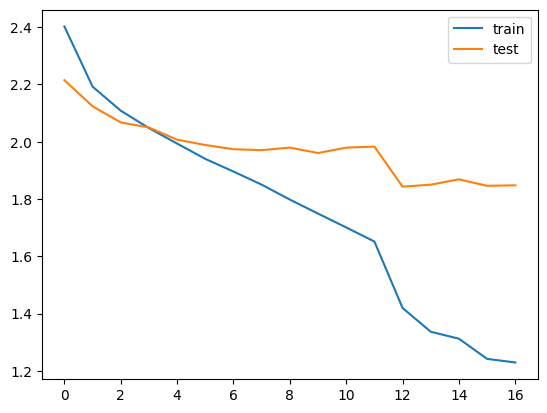

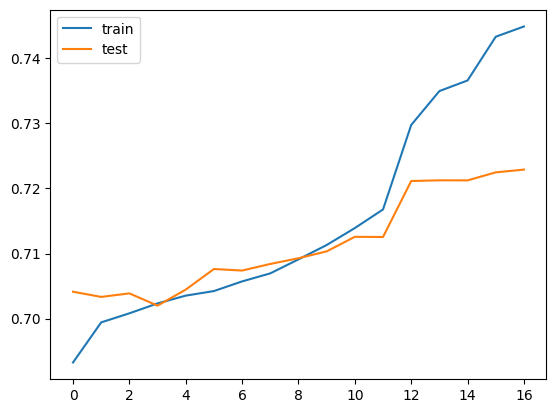

In [37]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [42]:
from tqdm import tqdm
from rouge_score import rouge_scorer

def evaluate_model(test_texts, test_summaries, max_len_text=config.MAX_LEN, max_len_summary=config.SUMMARY_LEN):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {
        'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
        'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
        'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
    }
    
    for text, summary in tqdm(zip(test_texts, test_summaries), "Evaluation"):
        generated_summary = summarize_text(text, max_len_text, max_len_summary)
        score = scorer.score(summary, generated_summary)
        
        for metric in ['rouge1', 'rouge2', 'rougeL']:
            scores[metric]['precision'].append(score[metric].precision)
            scores[metric]['recall'].append(score[metric].recall)
            scores[metric]['fmeasure'].append(score[metric].fmeasure)
    
    print("Calculating Mean Scores")
    mean_scores = {
        metric: {
            'precision': np.mean(values['precision']),
            'recall': np.mean(values['recall']),
            'fmeasure': np.mean(values['fmeasure'])
        }
        for metric, values in scores.items()
    }
    
    print(mean_scores)
    return mean_scores

test_texts = test_df['ctext'].tolist()
test_summaries = test_df['text'].tolist()
mean_scores = evaluate_model(test_texts, test_summaries)

print("ROUGE scores:")
for metric, values in mean_scores.items():
    print(f"{metric.upper()}: Precision: {values['precision']:.4f}, Recall: {values['recall']:.4f}, F-measure: {values['fmeasure']:.4f}")


Evaluation: 0it [00:00, ?it/s]

1/1 [==============================] - 0s 97ms/step


Evaluation: 1it [00:09,  9.99s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 2it [00:19,  9.60s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 3it [00:29,  9.85s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 4it [00:41, 10.77s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 5it [00:47,  9.06s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 6it [01:17, 16.20s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 7it [01:24, 13.27s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 8it [01:32, 11.51s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 9it [01:44, 11.56s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 10it [02:14, 17.30s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 11it [02:20, 13.89s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 12it [02:50, 18.81s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 13it [03:04, 17.15s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 14it [03:14, 15.26s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 15it [03:46, 20.01s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 16it [03:57, 17.60s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 17it [04:31, 22.29s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 18it [04:39, 18.08s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 19it [04:45, 14.41s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 20it [05:18, 20.10s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 21it [05:26, 16.54s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 22it [06:00, 21.70s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 23it [06:10, 18.11s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 24it [06:23, 16.60s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 25it [06:57, 21.72s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 26it [07:11, 19.52s/it]

1/1 [==============================] - 0s 115ms/step


Evaluation: 27it [07:42, 22.86s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 28it [07:53, 19.34s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 29it [08:01, 16.03s/it]

1/1 [==============================] - 0s 106ms/step


Evaluation: 30it [08:13, 14.85s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 31it [08:21, 12.85s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 32it [08:26, 10.51s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 33it [08:34,  9.49s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 34it [08:43,  9.35s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 35it [08:54,  9.96s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 36it [09:01,  9.17s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 37it [09:14, 10.38s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 38it [09:46, 16.79s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 39it [09:56, 14.65s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 40it [10:05, 13.04s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 41it [10:17, 12.56s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 42it [10:22, 10.45s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 43it [10:37, 11.92s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 44it [10:45, 10.48s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 45it [10:53,  9.91s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 46it [11:01,  9.42s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 47it [11:10,  9.18s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 48it [11:17,  8.58s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 49it [11:49, 15.48s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 50it [11:58, 13.47s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 51it [12:10, 13.29s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 52it [12:16, 10.83s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 53it [12:21,  9.19s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 54it [12:28,  8.65s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 55it [12:47, 11.80s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 56it [13:19, 17.59s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 57it [13:29, 15.58s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 58it [14:03, 21.09s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 59it [14:12, 17.43s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 60it [14:18, 13.87s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 61it [14:28, 12.78s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 62it [15:00, 18.44s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 63it [15:31, 22.32s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 64it [15:40, 18.29s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 65it [15:50, 15.67s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 66it [16:20, 20.23s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 67it [16:28, 16.31s/it]

1/1 [==============================] - 0s 107ms/step


Evaluation: 68it [16:35, 13.66s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 69it [16:45, 12.55s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 70it [16:50, 10.34s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 71it [16:56,  9.05s/it]

1/1 [==============================] - 0s 108ms/step


Evaluation: 72it [17:00,  7.58s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 73it [17:08,  7.69s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 74it [17:40, 14.73s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 75it [17:45, 12.04s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 76it [18:18, 18.39s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 77it [18:30, 16.37s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 78it [19:01, 20.81s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 79it [19:17, 19.17s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 80it [19:24, 15.55s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 81it [19:55, 20.18s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 82it [20:26, 23.50s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 83it [20:34, 18.87s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 84it [20:45, 16.48s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 85it [20:55, 14.48s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 86it [21:03, 12.59s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 87it [21:09, 10.56s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 88it [21:21, 11.00s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 89it [21:26,  9.22s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 90it [21:37,  9.80s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 91it [22:08, 16.15s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 92it [22:40, 20.78s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 93it [22:45, 16.25s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 94it [22:54, 14.02s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 95it [23:04, 12.74s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 96it [23:35, 18.24s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 97it [23:44, 15.45s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 98it [24:02, 16.16s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 99it [24:12, 14.30s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 100it [24:43, 19.28s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 101it [25:04, 19.94s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 102it [25:11, 15.93s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 103it [25:20, 14.05s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 104it [25:26, 11.58s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 105it [25:39, 11.89s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 106it [25:47, 10.96s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 107it [26:18, 16.84s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 108it [26:28, 14.90s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 109it [26:35, 12.54s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 110it [26:42, 10.67s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 111it [27:15, 17.34s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 112it [27:28, 16.01s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 113it [27:38, 14.40s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 114it [27:47, 12.66s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 115it [28:18, 18.13s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 116it [28:47, 21.58s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 117it [28:55, 17.42s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 118it [29:15, 18.14s/it]

1/1 [==============================] - 0s 111ms/step


Evaluation: 119it [29:22, 14.84s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 120it [29:28, 12.34s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 121it [29:59, 17.72s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 122it [30:07, 14.95s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 123it [30:12, 11.97s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 124it [30:21, 10.95s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 125it [30:37, 12.47s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 126it [30:49, 12.47s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 127it [31:04, 13.13s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 128it [31:36, 18.90s/it]

1/1 [==============================] - 0s 106ms/step


Evaluation: 129it [31:42, 15.02s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 130it [31:54, 14.07s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 131it [32:01, 12.04s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 132it [32:08, 10.26s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 133it [32:21, 11.08s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 134it [32:53, 17.45s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 135it [33:11, 17.60s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 136it [33:20, 15.13s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 137it [33:27, 12.55s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 138it [33:32, 10.49s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 139it [33:41,  9.85s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 140it [33:49,  9.37s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 141it [34:00,  9.76s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 142it [34:04,  8.20s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 143it [34:36, 15.13s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 144it [34:36, 10.78s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 145it [34:46, 10.56s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 146it [34:52,  8.99s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 147it [35:02,  9.41s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 148it [35:07,  8.14s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 149it [35:38, 14.96s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 150it [35:46, 12.94s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 151it [35:51, 10.54s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 152it [35:57,  9.00s/it]

1/1 [==============================] - 0s 107ms/step


Evaluation: 153it [36:05,  8.94s/it]

1/1 [==============================] - 0s 111ms/step


Evaluation: 154it [36:14,  8.73s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 155it [36:24,  9.30s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 156it [36:56, 16.01s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 157it [37:03, 13.33s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 158it [37:14, 12.57s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 159it [37:18, 10.16s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 160it [37:25,  9.23s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 161it [37:33,  8.64s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 162it [37:43,  9.22s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 163it [37:50,  8.52s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 164it [38:01,  9.23s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 165it [38:07,  8.20s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 166it [38:14,  7.85s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 167it [38:45, 14.94s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 168it [38:53, 12.89s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 169it [39:02, 11.69s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 170it [39:15, 11.86s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 171it [39:22, 10.62s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 172it [39:40, 12.76s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 173it [39:47, 11.13s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 174it [39:59, 11.16s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 175it [40:06, 10.10s/it]

1/1 [==============================] - 0s 108ms/step


Evaluation: 176it [40:37, 16.39s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 177it [40:45, 13.79s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 178it [40:50, 11.20s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 179it [40:58, 10.30s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 180it [41:07,  9.79s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 181it [41:38, 16.02s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 182it [41:44, 13.16s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 183it [41:51, 11.29s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 184it [41:57,  9.70s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 185it [42:02,  8.41s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 186it [42:08,  7.68s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 187it [42:19,  8.54s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 188it [42:25,  7.80s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 189it [42:33,  7.77s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 190it [42:39,  7.28s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 191it [42:46,  7.41s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 192it [43:03, 10.08s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 193it [43:07,  8.47s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 194it [43:20,  9.53s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 195it [43:26,  8.55s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 196it [43:33,  8.12s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 197it [44:03, 14.84s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 198it [44:20, 15.28s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 199it [44:33, 14.60s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 200it [44:40, 12.34s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 201it [45:13, 18.74s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 202it [45:25, 16.45s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 203it [45:35, 14.71s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 204it [46:07, 19.81s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 205it [46:20, 17.80s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 206it [46:27, 14.66s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 207it [46:36, 12.85s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 208it [46:45, 11.84s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 209it [47:17, 17.61s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 210it [47:29, 16.04s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 211it [48:00, 20.46s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 212it [48:05, 15.81s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 213it [48:12, 13.41s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 214it [48:22, 12.17s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 215it [48:33, 11.75s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 216it [48:43, 11.29s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 217it [48:50, 10.01s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 218it [49:02, 10.58s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 219it [49:08,  9.41s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 220it [49:15,  8.47s/it]

1/1 [==============================] - 0s 113ms/step


Evaluation: 221it [49:31, 10.80s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 222it [49:43, 11.32s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 223it [49:52, 10.59s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 224it [50:08, 12.14s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 225it [50:15, 10.56s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 226it [50:20,  8.96s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 227it [50:34, 10.50s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 228it [50:45, 10.70s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 229it [50:55, 10.46s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 230it [51:01,  8.90s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 231it [51:07,  8.12s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 232it [51:15,  8.16s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 233it [51:20,  7.26s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 234it [51:27,  7.24s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 235it [51:37,  7.96s/it]

1/1 [==============================] - 0s 114ms/step


Evaluation: 236it [52:07, 14.69s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 237it [52:15, 12.42s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 238it [52:19, 10.15s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 239it [52:29,  9.89s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 240it [52:35,  8.94s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 241it [52:41,  7.91s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 242it [52:49,  8.00s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 243it [53:02,  9.31s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 244it [53:13,  9.89s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 245it [53:44, 16.35s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 246it [53:50, 13.19s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 247it [53:57, 11.23s/it]

1/1 [==============================] - 0s 110ms/step


Evaluation: 248it [54:30, 17.88s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 249it [54:38, 14.74s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 250it [54:48, 13.52s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 251it [54:56, 11.94s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 252it [55:30, 18.29s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 253it [55:40, 15.98s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 254it [56:12, 20.87s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 255it [56:43, 23.80s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 256it [56:50, 18.76s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 257it [57:21, 22.34s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 258it [57:28, 17.91s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 259it [57:34, 14.26s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 260it [58:05, 19.37s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 261it [58:36, 22.87s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 262it [58:45, 18.60s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 263it [58:54, 15.86s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 264it [59:26, 20.60s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 265it [59:51, 21.95s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 266it [1:00:01, 18.22s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 267it [1:00:08, 15.06s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 268it [1:00:16, 12.85s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 269it [1:00:31, 13.35s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 270it [1:00:42, 12.83s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 271it [1:00:47, 10.37s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 272it [1:00:54,  9.26s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 273it [1:01:24, 15.69s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 274it [1:01:31, 12.89s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 275it [1:01:42, 12.38s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 276it [1:01:47, 10.19s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 277it [1:02:01, 11.39s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 278it [1:02:14, 11.91s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 279it [1:02:22, 10.62s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 280it [1:02:54, 16.97s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 281it [1:03:04, 15.08s/it]

1/1 [==============================] - 0s 123ms/step


Evaluation: 282it [1:03:37, 20.50s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 283it [1:03:45, 16.65s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 284it [1:04:02, 16.77s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 285it [1:04:34, 21.17s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 286it [1:04:46, 18.42s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 287it [1:05:17, 22.38s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 288it [1:05:21, 16.91s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 289it [1:05:52, 21.16s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 290it [1:06:23, 24.10s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 291it [1:06:30, 18.83s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 292it [1:07:00, 22.36s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 293it [1:07:10, 18.56s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 294it [1:07:21, 16.25s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 295it [1:07:29, 13.67s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 296it [1:07:34, 11.12s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 297it [1:07:42, 10.19s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 298it [1:07:54, 10.74s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 299it [1:07:59,  9.06s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 300it [1:08:31, 15.81s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 301it [1:08:38, 13.42s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 302it [1:08:44, 11.18s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 303it [1:08:49,  9.34s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 304it [1:08:56,  8.64s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 305it [1:09:08,  9.44s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 306it [1:09:15,  8.64s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 307it [1:09:25,  9.10s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 308it [1:09:38, 10.43s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 309it [1:09:57, 13.03s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 310it [1:10:10, 12.80s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 311it [1:10:20, 12.13s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 312it [1:10:51, 17.70s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 313it [1:11:22, 21.83s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 314it [1:11:31, 17.90s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 315it [1:11:37, 14.46s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 316it [1:11:54, 15.14s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 317it [1:12:05, 13.84s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 318it [1:12:11, 11.38s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 319it [1:12:44, 17.93s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 320it [1:12:56, 16.21s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 321it [1:13:26, 20.41s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 322it [1:13:58, 23.71s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 323it [1:14:28, 25.75s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 324it [1:14:34, 19.79s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 325it [1:14:40, 15.62s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 326it [1:14:46, 12.87s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 327it [1:15:17, 18.05s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 328it [1:15:47, 21.70s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 329it [1:16:18, 24.43s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 330it [1:16:23, 18.87s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 331it [1:16:55, 22.78s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 332it [1:17:05, 18.69s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 333it [1:17:15, 16.09s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 334it [1:17:46, 20.64s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 335it [1:17:53, 16.75s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 336it [1:18:03, 14.46s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 337it [1:18:08, 11.72s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 338it [1:18:39, 17.62s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 339it [1:18:47, 14.57s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 340it [1:19:18, 19.60s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 341it [1:19:27, 16.34s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 342it [1:19:58, 20.79s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 343it [1:20:05, 16.58s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 344it [1:20:11, 13.55s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 345it [1:20:42, 18.85s/it]

1/1 [==============================] - 0s 106ms/step


Evaluation: 346it [1:20:54, 16.51s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 347it [1:21:05, 14.92s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 348it [1:21:13, 13.00s/it]

1/1 [==============================] - 0s 108ms/step


Evaluation: 349it [1:21:22, 11.76s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 350it [1:21:26,  9.46s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 351it [1:21:32,  8.43s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 352it [1:21:48, 10.61s/it]

1/1 [==============================] - 0s 94ms/step


Evaluation: 353it [1:22:19, 16.67s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 354it [1:22:26, 13.89s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 355it [1:22:37, 12.98s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 356it [1:22:43, 10.78s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 357it [1:22:51, 10.05s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 358it [1:22:58,  9.18s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 359it [1:23:09,  9.70s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 360it [1:23:16,  9.01s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 361it [1:23:23,  8.41s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 362it [1:23:32,  8.48s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 363it [1:23:39,  7.86s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 364it [1:23:48,  8.32s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 365it [1:23:53,  7.38s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 366it [1:24:01,  7.59s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 367it [1:24:06,  6.81s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 368it [1:24:37, 14.14s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 369it [1:24:44, 11.99s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 370it [1:24:55, 11.43s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 371it [1:25:03, 10.68s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 372it [1:25:15, 11.05s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 373it [1:25:25, 10.51s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 374it [1:25:32,  9.52s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 375it [1:25:38,  8.63s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 376it [1:26:12, 16.20s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 377it [1:26:44, 20.94s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 378it [1:26:55, 17.82s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 379it [1:27:06, 15.84s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 380it [1:27:11, 12.72s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 381it [1:27:20, 11.36s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 382it [1:27:25,  9.43s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 383it [1:27:57, 16.26s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 384it [1:28:05, 13.99s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 385it [1:28:12, 11.69s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 386it [1:28:29, 13.39s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 387it [1:29:00, 18.73s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 388it [1:29:31, 22.43s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 389it [1:30:03, 25.15s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 390it [1:30:11, 20.00s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 391it [1:30:44, 23.96s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 392it [1:31:16, 26.40s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 393it [1:31:25, 21.28s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 394it [1:31:38, 18.66s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 395it [1:31:46, 15.38s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 396it [1:32:17, 20.19s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 397it [1:32:27, 17.22s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 398it [1:32:38, 15.08s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 399it [1:32:47, 13.30s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 400it [1:33:19, 18.86s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 401it [1:33:25, 15.21s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 402it [1:33:56, 19.98s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 403it [1:34:06, 16.87s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 404it [1:34:14, 14.32s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 405it [1:34:20, 11.62s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 406it [1:34:32, 11.73s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 407it [1:35:05, 18.12s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 408it [1:35:21, 17.63s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 409it [1:35:32, 15.70s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 410it [1:35:41, 13.45s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 411it [1:36:11, 18.67s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 412it [1:36:19, 15.41s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 413it [1:36:51, 20.28s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 414it [1:36:56, 15.89s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 415it [1:37:28, 20.58s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 416it [1:37:59, 23.81s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 417it [1:38:05, 18.24s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 418it [1:38:13, 15.17s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 419it [1:38:23, 13.85s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 420it [1:38:29, 11.49s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 421it [1:38:41, 11.58s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 422it [1:38:51, 10.94s/it]

1/1 [==============================] - 0s 106ms/step


Evaluation: 423it [1:39:22, 17.13s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 424it [1:39:35, 15.89s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 425it [1:40:08, 21.06s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 426it [1:40:20, 18.39s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 427it [1:40:33, 16.67s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 428it [1:40:41, 14.02s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 429it [1:40:59, 15.19s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 430it [1:41:10, 14.08s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 431it [1:41:17, 11.75s/it]

1/1 [==============================] - 0s 118ms/step


Evaluation: 432it [1:41:22,  9.85s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 433it [1:41:53, 16.31s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 434it [1:42:25, 20.86s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 435it [1:42:33, 16.91s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 436it [1:42:39, 13.73s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 437it [1:42:50, 13.08s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 438it [1:43:01, 12.39s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 439it [1:43:09, 10.88s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 440it [1:43:13,  8.94s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 441it [1:43:23,  9.29s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 442it [1:43:33,  9.31s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 443it [1:43:42,  9.29s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 444it [1:44:15, 16.48s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 445it [1:44:23, 13.92s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 446it [1:44:55, 19.31s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 447it [1:45:00, 14.97s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 448it [1:45:07, 12.70s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 449it [1:45:18, 12.05s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 450it [1:45:27, 11.32s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 451it [1:45:33,  9.75s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 452it [1:45:44, 10.16s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 453it [1:45:55, 10.34s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 454it [1:46:13, 12.62s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 455it [1:46:44, 18.12s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 456it [1:46:51, 14.72s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 457it [1:47:04, 14.19s/it]

1/1 [==============================] - 0s 106ms/step


Evaluation: 458it [1:47:35, 19.25s/it]

1/1 [==============================] - 0s 95ms/step


Evaluation: 459it [1:47:40, 15.07s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 460it [1:47:53, 14.50s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 461it [1:48:25, 19.66s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 462it [1:48:36, 16.99s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 463it [1:48:47, 15.18s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 464it [1:49:20, 20.61s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 465it [1:49:52, 23.93s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 466it [1:50:02, 19.68s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 467it [1:50:10, 16.44s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 468it [1:50:19, 14.00s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 469it [1:50:30, 13.06s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 470it [1:50:36, 11.15s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 471it [1:50:50, 11.94s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 472it [1:51:22, 17.82s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 473it [1:51:31, 15.32s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 474it [1:51:48, 15.71s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 475it [1:52:10, 17.71s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 476it [1:52:19, 15.04s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 477it [1:52:51, 20.06s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 478it [1:53:04, 18.19s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 479it [1:53:13, 15.34s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 480it [1:53:21, 12.98s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 481it [1:53:54, 19.16s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 482it [1:54:04, 16.34s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 483it [1:54:14, 14.47s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 484it [1:54:18, 11.42s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 485it [1:54:28, 10.74s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 486it [1:54:34,  9.56s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 487it [1:54:41,  8.74s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 488it [1:54:50,  8.80s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 489it [1:55:00,  8.98s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 490it [1:55:08,  8.82s/it]

1/1 [==============================] - 0s 99ms/step


Evaluation: 491it [1:55:39, 15.52s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 492it [1:56:10, 20.26s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 493it [1:56:16, 15.81s/it]

1/1 [==============================] - 0s 107ms/step


Evaluation: 494it [1:56:22, 12.90s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 495it [1:56:30, 11.48s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 496it [1:56:41, 11.40s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 497it [1:57:07, 15.63s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 498it [1:57:19, 14.68s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 499it [1:57:29, 13.13s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 500it [1:57:38, 11.99s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 501it [1:57:45, 10.40s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 502it [1:57:56, 10.68s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 503it [1:58:09, 11.23s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 504it [1:58:17, 10.41s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 505it [1:58:24,  9.42s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 506it [1:58:56, 16.01s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 507it [1:59:05, 13.95s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 508it [1:59:15, 12.96s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 509it [1:59:24, 11.63s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 510it [1:59:35, 11.37s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 511it [1:59:47, 11.60s/it]

1/1 [==============================] - 0s 101ms/step


Evaluation: 512it [1:59:55, 10.64s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 513it [2:00:28, 17.20s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 514it [2:00:38, 14.96s/it]

1/1 [==============================] - 0s 96ms/step


Evaluation: 515it [2:01:09, 19.87s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 516it [2:01:41, 23.60s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 517it [2:02:13, 26.13s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 518it [2:02:22, 21.03s/it]

1/1 [==============================] - 0s 108ms/step


Evaluation: 519it [2:02:34, 18.34s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 520it [2:02:46, 16.29s/it]

1/1 [==============================] - 0s 104ms/step


Evaluation: 521it [2:02:59, 15.38s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 522it [2:03:04, 12.25s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 523it [2:03:11, 10.72s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 524it [2:03:20, 10.22s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 525it [2:03:25,  8.70s/it]

1/1 [==============================] - 0s 98ms/step


Evaluation: 526it [2:03:32,  8.20s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 527it [2:03:38,  7.49s/it]

1/1 [==============================] - 0s 105ms/step


Evaluation: 528it [2:03:47,  7.87s/it]

1/1 [==============================] - 0s 100ms/step


Evaluation: 529it [2:03:55,  7.96s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 530it [2:04:05,  8.63s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 531it [2:04:13,  8.29s/it]

1/1 [==============================] - 0s 97ms/step


Evaluation: 532it [2:04:40, 14.04s/it]

1/1 [==============================] - 0s 102ms/step


Evaluation: 533it [2:04:52, 13.23s/it]

1/1 [==============================] - 0s 103ms/step


Evaluation: 534it [2:05:23, 14.09s/it]

Calculating Mean Scores
{'rouge1': {'precision': 0.18237303322499374, 'recall': 0.1730843023951982, 'fmeasure': 0.16577834182301804}, 'rouge2': {'precision': 0.027540391066902876, 'recall': 0.02820362230593347, 'fmeasure': 0.02637000058962339}, 'rougeL': {'precision': 0.14792701880747436, 'recall': 0.14057317974627012, 'fmeasure': 0.13403174655251932}}
ROUGE scores:
ROUGE1: Precision: 0.1824, Recall: 0.1731, F-measure: 0.1658
ROUGE2: Precision: 0.0275, Recall: 0.0282, F-measure: 0.0264
ROUGEL: Precision: 0.1479, Recall: 0.1406, F-measure: 0.1340


ROUGE scores:
ROUGE1: Precision: 0.1824, Recall: 0.1731, F-measure: 0.1658
ROUGE2: Precision: 0.0275, Recall: 0.0282, F-measure: 0.0264
ROUGEL: Precision: 0.1479, Recall: 0.1406, F-measure: 0.1340


## T5-GRU

In [ ]:
import tensorflow as tf

# Define inputs
input_ids = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(config.MAX_LEN,), dtype=tf.int32, name="attention_mask")
decoder_inputs = tf.keras.Input(shape=(config.SUMMARY_LEN,), dtype=tf.int32, name="decoder_inputs")

# Encoder model (T5)
encoder_model = TFT5EncoderModel.from_pretrained('t5-base')
encoder_outputs = encoder_model(input_ids, attention_mask=attention_mask).last_hidden_state

# Embedding layer for decoder inputs
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size, output_dim=300, 
    input_length=config.SUMMARY_LEN, trainable=False, 
    name="embedding"
)
decoder_inputs_embedded = embedding_layer(decoder_inputs)

# GRU layer in decoder
decoder_gru = tf.keras.layers.GRU(768, return_sequences=True, return_state=True, name="decoder_gru")
decoder_outputs, _ = decoder_gru(
    decoder_inputs_embedded, initial_state=encoder_outputs[:, 0, :]
)

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer for predictions
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax', name="TD_dec_dense"))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define model
gru_model = tf.keras.Model(inputs=[input_ids, attention_mask, decoder_inputs], outputs=decoder_outputs)

gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

gru_model.summary()
